In [1]:
import sys
sys.path.append('../')

In [2]:
import time
import os

import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [4]:
from tensorflow.keras.metrics import Metric
class RSquare(Metric):
    """Compute R^2 score.
     This is also called as coefficient of determination.
     It tells how close are data to the fitted regression line.
     - Highest score can be 1.0 and it indicates that the predictors
       perfectly accounts for variation in the target.
     - Score 0.0 indicates that the predictors do not
       account for variation in the target.
     - It can also be negative if the model is worse.
     Usage:
     ```python
     actuals = tf.constant([1, 4, 3], dtype=tf.float32)
     preds = tf.constant([2, 4, 4], dtype=tf.float32)
     result = tf.keras.metrics.RSquare()
     result.update_state(actuals, preds)
     print('R^2 score is: ', r1.result().numpy()) # 0.57142866
    ```
    """

    def __init__(self, name='r_square', dtype=tf.float32):
        super(RSquare, self).__init__(name=name, dtype=dtype)
        self.squared_sum = self.add_weight("squared_sum", initializer="zeros")
        self.sum = self.add_weight("sum", initializer="zeros")
        self.res = self.add_weight("residual", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        self.squared_sum.assign_add(tf.reduce_sum(y_true**2))
        self.sum.assign_add(tf.reduce_sum(y_true))
        self.res.assign_add(
            tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred))))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        mean = self.sum / self.count
        total = self.squared_sum - 2 * self.sum * mean + self.count * mean**2
        return 1 - (self.res / total)

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.squared_sum.assign(0.0)
        self.sum.assign(0.0)
        self.res.assign(0.0)
        self.count.assign(0.0)

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [7]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

## Data preparation

### Hyperparameters

In [8]:
BEST_PATHS       = ['./models/best_MLP.h5', 
                    './models/best_LSTM.h5',
                    './models/best_AE_LSTM.h5',
                    './models/best_BiLSTM.h5',
                    './models/best_AE_BiLSTM.h5']
TRANS_BEST_PATHS = ['./models/trans_MLP.h5', 
                    './models/trans_LSTM.h5',
                    './models/trans_AE_LSTM.h5',
                    './models/trans_BiLSTM.h5',
                    './models/trans_AE_BiLSTM.h5']
RAW_BEST_PATHS   = ['./models/raw_MLP.h5', 
                    './models/raw_LSTM.h5',
                    './models/raw_AE_LSTM.h5',
                    './models/raw_BiLSTM.h5',
                    './models/raw_AE_BiLSTM.h5']
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_HIDDEN = 256

### data loading

In [9]:
l = np.load('./env_set/val_tom_dataset.npz')
train_input = l['train_input']
train_label = l['train_label']
test_input = l['test_input']
test_label = l['test_label']
MAXS = l['MAXS']
MINS = l['MINS']

TIME_STEPS = l['TIME_STEPS']
OUTPUT_SIZE = l['OUTPUT_SIZE']
NUM_FEATURES = train_input.shape[-1]

In [10]:
print(train_input.shape)
print(train_label.shape)
print()
print(test_input.shape)
print(test_label.shape)

(37951, 24, 5)
(37951, 24, 5)

(83356, 24, 5)
(83356, 24, 5)


In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

# Transfer learning - AE_LSTM

### Pre-trained AE loading

In [12]:
class RetrainLayer(tf.keras.layers.Layer):
    def __init__(self, num_hidden, activation=tf.nn.relu):
        super(RetrainLayer, self).__init__()
        self.num_hidden = num_hidden
        
        self.dense = tf.keras.layers.Dense(self.num_hidden, activation=activation, kernel_initializer='he_uniform')
        
    def call(self, inp):
        return self.dense(inp)

In [13]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, encoding_size):
        super(Encoder, self).__init__()
        
        self.num_hiddens = num_hiddens
        self.encoding_size = encoding_size
        
        self.denses = [tf.keras.layers.Dense(self.num_hiddens[_], activation=tf.nn.relu, kernel_initializer='he_uniform')
                       for _ in range(len(self.num_hiddens))]
        
        self.output_layer = tf.keras.layers.Dense(self.encoding_size, activation=tf.nn.sigmoid)
        
    def call(self, inp):
        for _ in range(len(self.num_hiddens)):
            inp = self.denses[_](inp)
        
        return self.output_layer(inp)        

In [14]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, original_size):
        super(Decoder, self).__init__()
        
        self.num_hiddens = num_hiddens[::-1]
        self.original_size = original_size
        
        self.denses = [tf.keras.layers.Dense(self.num_hiddens[_], activation=tf.nn.relu, kernel_initializer='he_uniform')
                       for _ in range(len(self.num_hiddens))]
        
    def call(self, inp):
        for _ in range(len(self.num_hiddens)):
            inp = self.denses[_](inp)
        
        return inp

In [15]:
class Autoencoder(tf.keras.Model):
    def __init__(self, num_hiddens, encoding_size, original_size):
        super(Autoencoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.encoding_size = encoding_size
        self.original_size = original_size
        
        self.in_retrain_layer = RetrainLayer(self.num_hiddens[0])
        self.encoder = Encoder(self.num_hiddens, self.encoding_size)
        self.decoder = Decoder(self.num_hiddens, self.original_size)
        self.out_retrain_layer = RetrainLayer(self.original_size, activation = tf.nn.sigmoid)
        
    def call(self, inp, need_code=False, decoding=None):
        inp = self.in_retrain_layer(inp)
        encoded_values = self.encoder(inp)
        if decoding is not None:
            decoding = self.decoder(decoding)
            return self.out_retrain_layer(decoding)
        if not need_code:
            encoded_values = self.decoder(encoded_values)
            return self.out_retrain_layer(encoded_values)
        else:
            return encoded_values

In [16]:
num_hiddens = [32, 16]
encoding_size = 8
original_size = 5
autoencoder = Autoencoder(num_hiddens, encoding_size, original_size)

In [17]:
autoencoder_copy = Autoencoder(num_hiddens, encoding_size, original_size)

In [18]:
autoencoder_copy.load_weights('./checkpoints/trained_AE')
autoencoder_copy.save_weights('./checkpoints/used_AE')
autoencoder_copy.load_weights('./checkpoints/used_AE')

### Transfer learning AE

In [19]:
class TransAE(tf.keras.Model):
    def __init__(self, num_hiddens, trained_encoder, trained_decoder):
        super(TransAE, self).__init__()
        self.num_hiddens = num_hiddens
        self.encoding_size = encoding_size
        self.original_size = original_size
        
        self.in_retrain_layer = RetrainLayer(self.num_hiddens[0])
        self.encoder = trained_encoder
        self.decoder = trained_decoder
        self.out_retrain_layer = RetrainLayer(self.original_size, activation = tf.nn.sigmoid)
        
    def call(self, inp, need_code=False, decoding=None):
        inp = self.in_retrain_layer(inp)
        encoded_values = self.encoder(inp)
        if decoding is not None:
            decoding = self.decoder(decoding)
            return self.out_retrain_layer(decoding)
        if not need_code:
            encoded_values = self.decoder(encoded_values)
            return self.out_retrain_layer(encoded_values)
        else:
            return encoded_values

In [20]:
autoencoder_copy.trainable = False

In [21]:
for layer in autoencoder_copy.layers:
    print(layer)

In [22]:
trans_ae = TransAE(num_hiddens, autoencoder_copy.get_layer(index=1), autoencoder_copy.get_layer(index=2))
trans_opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [23]:
for layer in trans_ae.layers:
    print(layer)

In [24]:
for layer in trans_ae.layers:
    print(layer.trainable)

True
False
False
True


In [25]:
def loss(model, original):
    reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
    return reconstruction_error

In [26]:
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)

In [27]:
trainset = np.concatenate([train_input, train_label], axis=0).astype(np.float32)
testset = np.concatenate([test_input, test_label], axis=0).astype(np.float32)

In [28]:
ae_train_dataset = tf.data.Dataset.from_tensor_slices((trainset, trainset))
ae_train_dataset = ae_train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).repeat()
ae_test_dataset = tf.data.Dataset.from_tensor_slices((testset, testset))
ae_test_dataset = ae_test_dataset.batch(BATCH_SIZE)

In [ ]:
EPOCHS = 150
prev_test_loss = 100.0
count = 0
for epoch in range(EPOCHS):
    for step, (inp, tar) in enumerate(ae_train_dataset):
        train(loss, trans_ae, trans_opt, inp)
        loss_values = loss(trans_ae, inp)

        if step % 100 == 0:
            test_loss = 0
            for step_, (inp_, tar_) in enumerate(ae_test_dataset):
                test_loss += loss(trans_ae, inp_)

                if step_ > 500:
                    test_loss /= 100
                    break
            if test_loss.numpy() < prev_test_loss:
                trans_ae.save_weights('./models/trans_ae')
                prev_test_loss = test_loss.numpy()
                print('Model saved.')
                count = 0
            elif (test_loss.numpy() - prev_test_loss) < 0.01:
                count += 1
                if count > 200:
                    break
            print('Epoch {} batch {} train loss: {:.4f} test loss: {:.4f}'
                  .format(epoch, step, loss_values.numpy(), test_loss.numpy()))
    if count > 200:
        print('Early stopping.')
        break

In [29]:
trans_ae.load_weights('./models/trans_ae')
trans_ae.trainable = True
trans_opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE/10)

In [30]:
def loss_(model, original):
    reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
    return reconstruction_error

In [31]:
def train_(loss, model, opt, original):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)

In [ ]:
EPOCHS = 150
prev_test_loss = 100.0
count = 0
for epoch in range(EPOCHS):
    for step, (inp, tar) in enumerate(ae_train_dataset):
        train_(loss_, trans_ae, trans_opt, inp)
        loss_values = loss_(trans_ae, inp)

        if step % 100 == 0:
            test_loss = 0
            for step_, (inp_, tar_) in enumerate(ae_test_dataset):
                test_loss += loss_(trans_ae, inp_)

                if step_ > 500:
                    test_loss /= 100
                    break
            if test_loss.numpy() < prev_test_loss:
                trans_ae.save_weights('./models/trans_ae')
                prev_test_loss = test_loss.numpy()
                print('Model saved.')
                count = 0
            elif (test_loss.numpy() - prev_test_loss) < 0.01:
                count += 1
                if count > 200:
                    break
            print('Epoch {} batch {} train loss: {:.4f} test loss: {:.4f}'
                  .format(epoch, step, loss_values.numpy(), test_loss.numpy()))
    if count > 200:
        print('Early stopping.')
        break

In [32]:
trans_ae.load_weights('./models/trans_ae')
print('transfered AE is ready.')

transfered AE is ready.


### transfer learning LSTM

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [34]:
trans_enc_train_input = []
trans_enc_train_label = []
trans_enc_test_input = []
trans_enc_test_label = []
for step, (inp, tar) in enumerate(train_dataset):
    trans_enc_train_input.append(trans_ae(inp, True))
    trans_enc_train_label.append(trans_ae(tar, True))
for step, (inp, tar) in enumerate(test_dataset):
    trans_enc_test_input.append(trans_ae(inp, True))
    trans_enc_test_label.append(trans_ae(tar, True))
trans_enc_train_input = tf.concat(trans_enc_train_input, axis=0)
trans_enc_train_label = tf.concat(trans_enc_train_label, axis=0)
trans_enc_test_input = tf.concat(trans_enc_test_input, axis=0)
trans_enc_test_label = tf.concat(trans_enc_test_label, axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [35]:
trans_enc_train_dataset = tf.data.Dataset.from_tensor_slices((trans_enc_train_input, trans_enc_train_label))
trans_enc_train_dataset = trans_enc_train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).repeat()
trans_enc_test_dataset = tf.data.Dataset.from_tensor_slices((trans_enc_test_input, trans_enc_test_label))
trans_enc_test_dataset = trans_enc_test_dataset.batch(BATCH_SIZE)

In [36]:
ae_lstm_model_copy = tf.keras.models.load_model(BEST_PATHS[2])
ae_lstm_model_copy.save(TRANS_BEST_PATHS[2])
ae_lstm_model_copy.trainable = False

In [37]:
trans_ae_lstm_model = tf.keras.Sequential([ae_lstm_model_copy.get_layer(index=0), 
                                           ae_lstm_model_copy.get_layer(index=1),
                                           tf.keras.layers.Dense(encoding_size)])

In [38]:
trans_ae_lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [39]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=TRANS_BEST_PATHS[2],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [40]:
trans_ae_lstm_model.fit(
    trans_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = trans_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
142/144 [============================>.] - ETA: 0s - loss: 0.0359
Epoch 00001: val_loss improved from inf to 0.00169, saving model to ./models/trans_AE_LSTM.h5
144/144 [==============================] - 7s 50ms/step - loss: 0.0354 - val_loss: 0.0017
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 00002: val_loss improved from 0.00169 to 0.00089, saving model to ./models/trans_AE_LSTM.h5
144/144 [==============================] - 6s 40ms/step - loss: 0.0017 - val_loss: 8.9387e-04
Epoch 3/150
142/144 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00003: val_loss improved from 0.00089 to 0.00072, saving model to ./models/trans_AE_LSTM.h5
144/144 [==============================] - 6s 39ms/step - loss: 0.0010 - val_loss: 7.1744e-04
Epoch 4/150
142/144 [============================>.] - ETA: 0s - loss: 8.3645e-04
Epoch 00004: val_loss improved from 0.00072 to 0.00059, saving model to .

In [41]:
trans_ae_lstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[2])
trans_ae_lstm_model.trainable = True
trans_ae_lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
                   loss = tf.keras.losses.MeanSquaredError())

In [42]:
trans_ae_lstm_model.fit(
    trans_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = trans_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
142/144 [============================>.] - ETA: 0s - loss: 6.1712e-04
Epoch 00001: val_loss did not improve from 0.00026
144/144 [==============================] - 7s 48ms/step - loss: 6.1455e-04 - val_loss: 2.7123e-04
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 3.5618e-04
Epoch 00002: val_loss did not improve from 0.00026
144/144 [==============================] - 5s 38ms/step - loss: 3.5712e-04 - val_loss: 2.6225e-04
Epoch 3/150
143/144 [============================>.] - ETA: 0s - loss: 3.4979e-04
Epoch 00003: val_loss did not improve from 0.00026
144/144 [==============================] - 5s 37ms/step - loss: 3.5030e-04 - val_loss: 2.8056e-04
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 3.8471e-04
Epoch 00004: val_loss improved from 0.00026 to 0.00025, saving model to ./models/trans_AE_LSTM.h5
144/144 [==============================] - 5s 37ms/step - loss: 3.8395e-04 - val_los

In [43]:
raw_ae = Autoencoder(num_hiddens, encoding_size, original_size)
raw_opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE/10)

In [ ]:
EPOCHS = 150
prev_test_loss = 100.0
count = 0
for epoch in range(EPOCHS):
    for step, (inp, tar) in enumerate(ae_train_dataset):
        train(loss, raw_ae, raw_opt, inp)
        loss_values = loss(raw_ae, inp)

        if step % 100 == 0:
            test_loss = 0
            for step_, (inp_, tar_) in enumerate(ae_test_dataset):
                test_loss += loss(raw_ae, inp_)

                if step_ > 500:
                    test_loss /= 100
                    break
            if test_loss.numpy() < prev_test_loss:
                trans_ae.save_weights('./models/raw_ae')
                prev_test_loss = test_loss.numpy()
                print('Model saved.')
                count = 0
            elif (test_loss.numpy() - prev_test_loss) < 0.01:
                count += 1
                if count > 200:
                    break
            print('Epoch {} batch {} train loss: {:.4f} test loss: {:.4f}'
                  .format(epoch, step, loss_values.numpy(), test_loss.numpy()))
    if count > 200:
        print('Early stopping.')
        break

In [44]:
raw_ae.load_weights('./models/raw_ae')
print('raw AE is ready.')

raw AE is ready.


In [45]:
raw_enc_train_input = []
raw_enc_train_label = []
raw_enc_test_input = []
raw_enc_test_label = []
for step, (inp, tar) in enumerate(train_dataset):
    raw_enc_train_input.append(raw_ae(inp, True))
    raw_enc_train_label.append(raw_ae(tar, True))
for step, (inp, tar) in enumerate(test_dataset):
    raw_enc_test_input.append(raw_ae(inp, True))
    raw_enc_test_label.append(raw_ae(tar, True))
raw_enc_train_input = tf.concat(raw_enc_train_input, axis=0)
raw_enc_train_label = tf.concat(raw_enc_train_label, axis=0)
raw_enc_test_input = tf.concat(raw_enc_test_input, axis=0)
raw_enc_test_label = tf.concat(raw_enc_test_label, axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [46]:
raw_enc_train_dataset = tf.data.Dataset.from_tensor_slices((raw_enc_train_input, raw_enc_train_label))
raw_enc_train_dataset = raw_enc_train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).repeat()
raw_enc_test_dataset = tf.data.Dataset.from_tensor_slices((raw_enc_test_input, raw_enc_test_label))
raw_enc_test_dataset = raw_enc_test_dataset.batch(BATCH_SIZE)

In [47]:
raw_ae_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, input_shape=[TIME_STEPS, encoding_size], return_sequences=True),
    tf.keras.layers.LayerNormalization(), # TEST
    tf.keras.layers.Dense(encoding_size)
])

In [48]:
raw_ae_lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [49]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=RAW_BEST_PATHS[2],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [50]:
raw_ae_lstm_model.fit(
    raw_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = raw_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
140/144 [============================>.] - ETA: 0s - loss: 0.0328
Epoch 00001: val_loss improved from inf to 0.00109, saving model to ./models/raw_AE_LSTM.h5
144/144 [==============================] - 5s 36ms/step - loss: 0.0320 - val_loss: 0.0011
Epoch 2/150
141/144 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00002: val_loss improved from 0.00109 to 0.00065, saving model to ./models/raw_AE_LSTM.h5
144/144 [==============================] - 2s 14ms/step - loss: 0.0012 - val_loss: 6.4888e-04
Epoch 3/150
141/144 [============================>.] - ETA: 0s - loss: 8.3846e-04
Epoch 00003: val_loss improved from 0.00065 to 0.00060, saving model to ./models/raw_AE_LSTM.h5
144/144 [==============================] - 2s 13ms/step - loss: 8.3749e-04 - val_loss: 5.9617e-04
Epoch 4/150
142/144 [============================>.] - ETA: 0s - loss: 7.2668e-04
Epoch 00004: val_loss did not improve from 0.00060
144/144 [===========

### Model evaluation

In [51]:
# Data preparation for AE
encoded_test_input = []
encoded_test_label = []
for step, (inp, tar) in enumerate(test_dataset):
    encoded_test_input.append(autoencoder(inp, True))
    encoded_test_label.append(autoencoder(tar, True))
encoded_test_input = tf.concat(encoded_test_input, axis=0)
encoded_test_label = tf.concat(encoded_test_label, axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [52]:
encoded_test_dataset = tf.data.Dataset.from_tensor_slices((encoded_test_input, encoded_test_label))
encoded_test_dataset = encoded_test_dataset.batch(BATCH_SIZE)

In [53]:
ae_lstm_model = tf.keras.models.load_model(BEST_PATHS[2])
trans_ae_lstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[2])
raw_ae_lstm_model = tf.keras.models.load_model(RAW_BEST_PATHS[2])

In [54]:
_ = ae_lstm_model.predict(encoded_test_dataset)
ae_lstm_pred = autoencoder(train_input[0:1, :, :], decoding=_)
_ = trans_ae_lstm_model.predict(trans_enc_test_dataset)
trans_ae_lstm_pred = trans_ae(train_input[0:1, :, :], decoding=_)
_ = raw_ae_lstm_model.predict(trans_enc_test_dataset)
raw_ae_lstm_pred = raw_ae(train_input[0:1, :, :], decoding=_)

[0, 50, 0, 50]

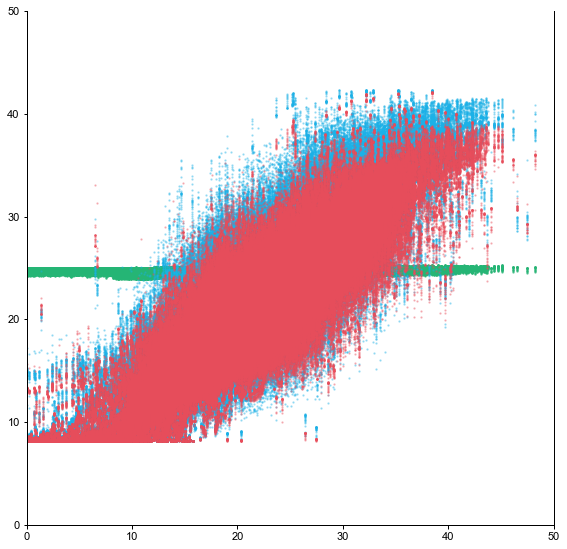

In [55]:
fig = plt.figure(figsize=((6/2.54)*4, (6/2.54)*4))

plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*ae_lstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[3], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*raw_ae_lstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[4], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*trans_ae_lstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[0], s=2, alpha=0.3
           )
plt.axis([0,50,0,50])

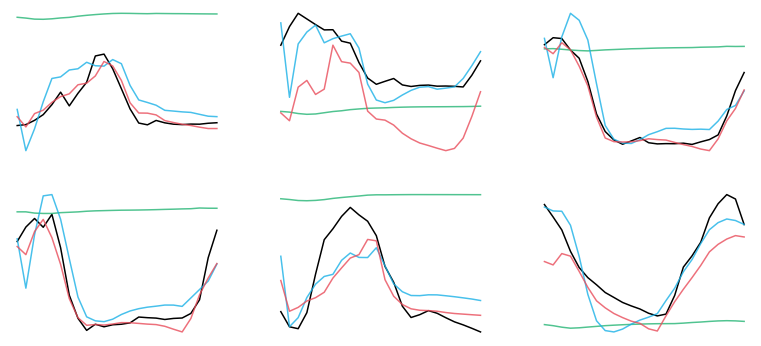

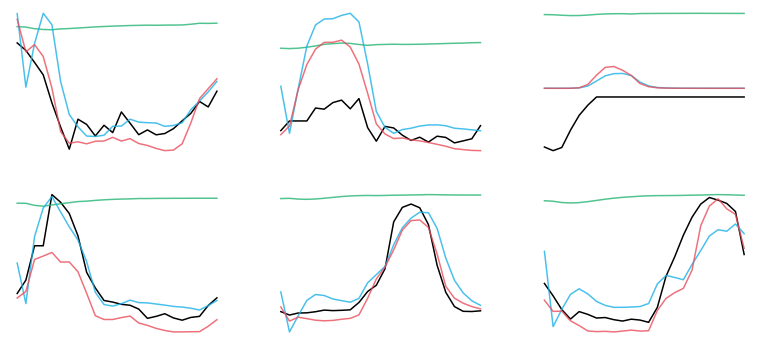

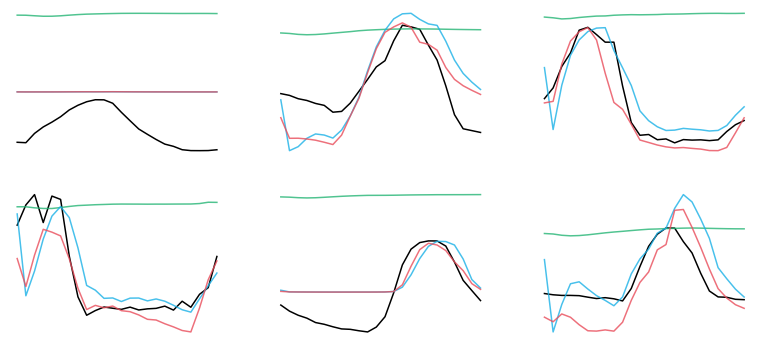

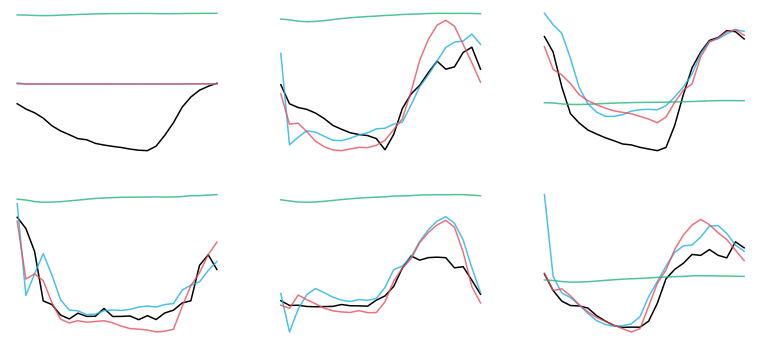

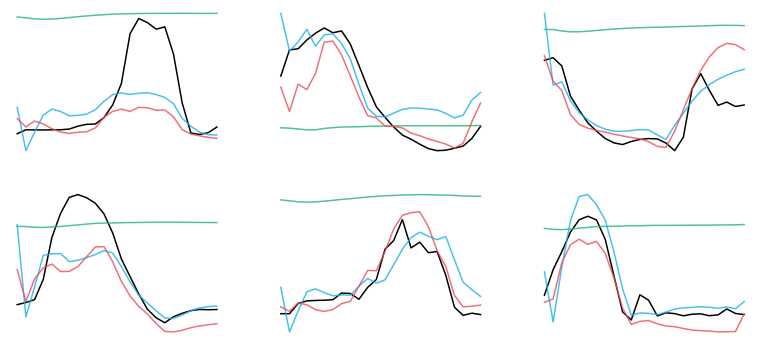

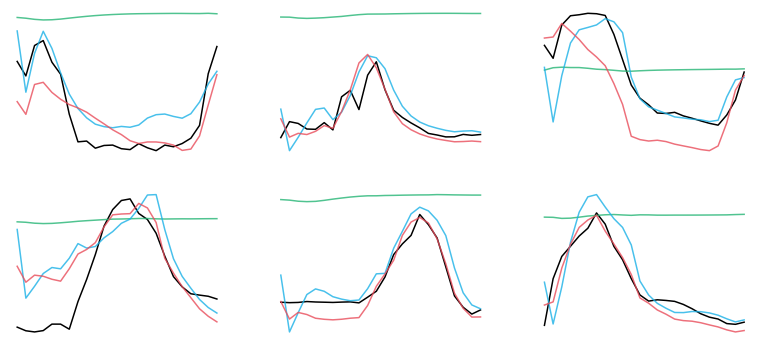

In [56]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (6):

        NUMBERS = np.arange(1, ae_lstm_pred.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*4, (6/2.54)*4))
        
        i=0
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, test_label[NUMBER, :, i], c='k', alpha=1) #measured
            expect1 = plt.plot(x_t, ae_lstm_pred[NUMBER, :, i], c=cmap[3], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, raw_ae_lstm_pred[NUMBER, :, i], c=cmap[4], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, trans_ae_lstm_pred[NUMBER, :, i], c=cmap[0], alpha=0.8) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1

### transfer learning BiLSTM

In [57]:
ae_bilstm_model_copy = tf.keras.models.load_model(BEST_PATHS[4])
ae_bilstm_model_copy.save(TRANS_BEST_PATHS[4])
ae_bilstm_model_copy.trainable = False

In [58]:
trans_ae_bilstm_model = tf.keras.Sequential([ae_bilstm_model_copy.get_layer(index=0), 
                                       ae_bilstm_model_copy.get_layer(index=1),
                                       tf.keras.layers.Dense(encoding_size)])

In [59]:
trans_ae_bilstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [60]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=TRANS_BEST_PATHS[4],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [61]:
trans_ae_bilstm_model.fit(
    trans_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = trans_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
143/144 [============================>.] - ETA: 0s - loss: 0.0720
Epoch 00001: val_loss improved from inf to 0.00417, saving model to ./models/trans_AE_BiLSTM.h5
144/144 [==============================] - 11s 77ms/step - loss: 0.0715 - val_loss: 0.0042
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 0.0031
Epoch 00002: val_loss improved from 0.00417 to 0.00137, saving model to ./models/trans_AE_BiLSTM.h5
144/144 [==============================] - 8s 58ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 3/150
143/144 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00003: val_loss improved from 0.00137 to 0.00084, saving model to ./models/trans_AE_BiLSTM.h5
144/144 [==============================] - 8s 59ms/step - loss: 0.0014 - val_loss: 8.4375e-04
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 9.5148e-04
Epoch 00004: val_loss improved from 0.00084 to 0.00068, saving model t

In [62]:
trans_ae_bilstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[4])
trans_ae_bilstm_model.trainable = True
trans_ae_bilstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
                   loss = tf.keras.losses.MeanSquaredError())

In [63]:
trans_ae_bilstm_model.fit(
    trans_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = trans_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
142/144 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00001: val_loss did not improve from 0.00028
144/144 [==============================] - 11s 76ms/step - loss: 0.0013 - val_loss: 3.1315e-04
Epoch 2/150
142/144 [============================>.] - ETA: 0s - loss: 3.6012e-04
Epoch 00002: val_loss improved from 0.00028 to 0.00025, saving model to ./models/trans_AE_BiLSTM.h5
144/144 [==============================] - 9s 60ms/step - loss: 3.5944e-04 - val_loss: 2.5198e-04
Epoch 3/150
143/144 [============================>.] - ETA: 0s - loss: 3.7004e-04
Epoch 00003: val_loss did not improve from 0.00025
144/144 [==============================] - 9s 59ms/step - loss: 3.6963e-04 - val_loss: 3.2624e-04
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 3.9988e-04
Epoch 00004: val_loss did not improve from 0.00025
144/144 [==============================] - 9s 59ms/step - loss: 3.9944e-04 - val_loss: 2.

In [64]:
raw_ae_bilstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True),
                                  input_shape=[TIME_STEPS, encoding_size]),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(encoding_size)
])

In [65]:
raw_ae_bilstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [66]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=RAW_BEST_PATHS[4],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [67]:
raw_ae_bilstm_model.fit(
    raw_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = raw_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
142/144 [============================>.] - ETA: 0s - loss: 0.0846
Epoch 00001: val_loss improved from inf to 0.00094, saving model to ./models/raw_AE_BiLSTM.h5
144/144 [==============================] - 11s 74ms/step - loss: 0.0834 - val_loss: 9.4433e-04
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 8.9396e-04
Epoch 00002: val_loss improved from 0.00094 to 0.00059, saving model to ./models/raw_AE_BiLSTM.h5
144/144 [==============================] - 4s 28ms/step - loss: 8.9207e-04 - val_loss: 5.9203e-04
Epoch 3/150
142/144 [============================>.] - ETA: 0s - loss: 6.4017e-04
Epoch 00003: val_loss improved from 0.00059 to 0.00044, saving model to ./models/raw_AE_BiLSTM.h5
144/144 [==============================] - 4s 28ms/step - loss: 6.3876e-04 - val_loss: 4.3662e-04
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 5.2791e-04
Epoch 00004: val_loss did not improve from 0.00044
1

### Model evaluation

In [68]:
ae_bilstm_model = tf.keras.models.load_model(BEST_PATHS[4])
trans_ae_bilstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[4])
raw_ae_bilstm_model = tf.keras.models.load_model(RAW_BEST_PATHS[4])

In [69]:
_ = ae_bilstm_model.predict(encoded_test_dataset)
ae_bilstm_pred = autoencoder(train_input[0:1, :, :], decoding=_)
_ = trans_ae_bilstm_model.predict(trans_enc_test_dataset)
trans_ae_bilstm_pred = trans_ae(train_input[0:1, :, :], decoding=_)
_ = raw_ae_bilstm_model.predict(trans_enc_test_dataset)
raw_ae_bilstm_pred = raw_ae(train_input[0:1, :, :], decoding=_)

[0, 50, 0, 50]

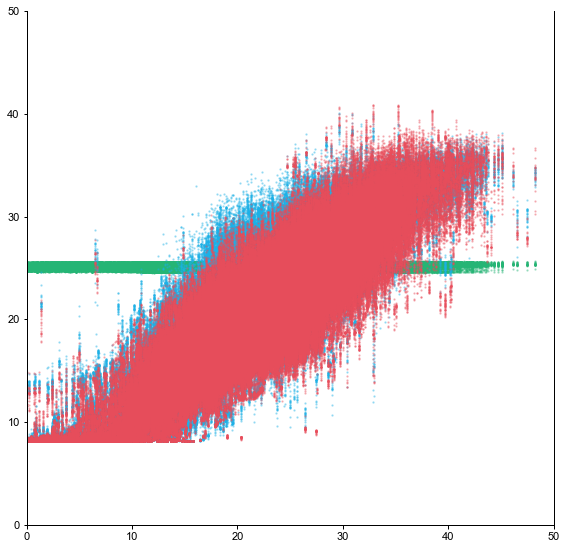

In [70]:
fig = plt.figure(figsize=((6/2.54)*4, (6/2.54)*4))

plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*ae_bilstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[3], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*raw_ae_bilstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[4], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*trans_ae_bilstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[0], s=2, alpha=0.3
           )
plt.axis([0,50,0,50])

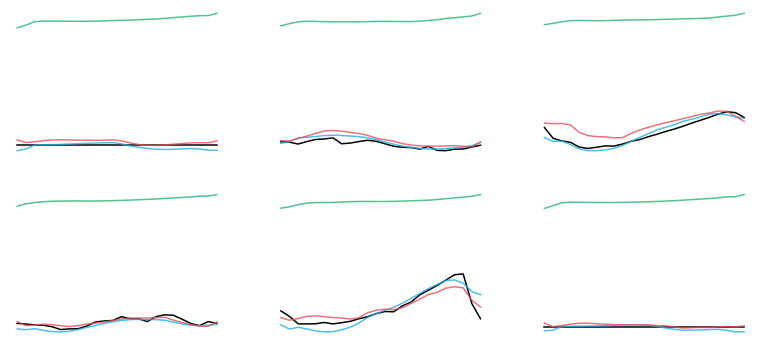

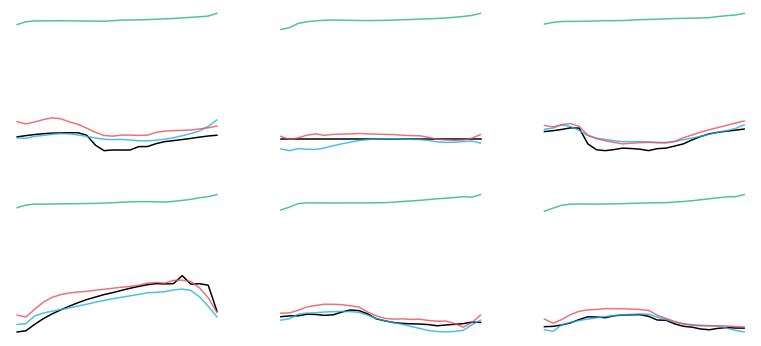

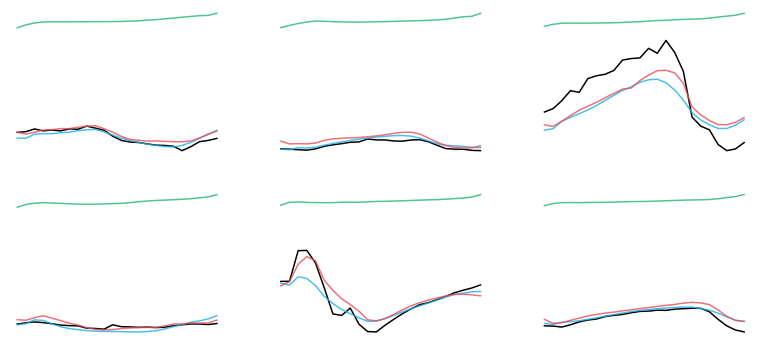

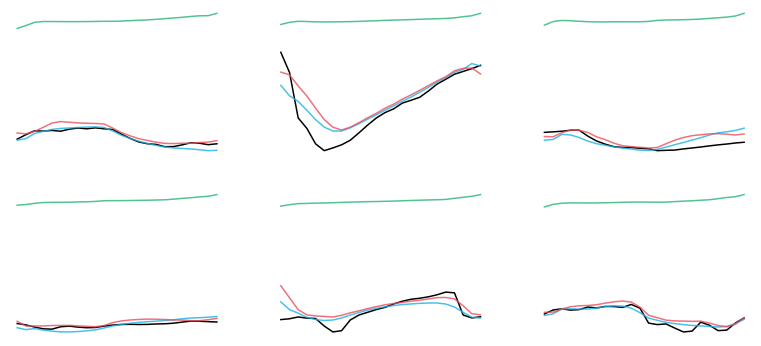

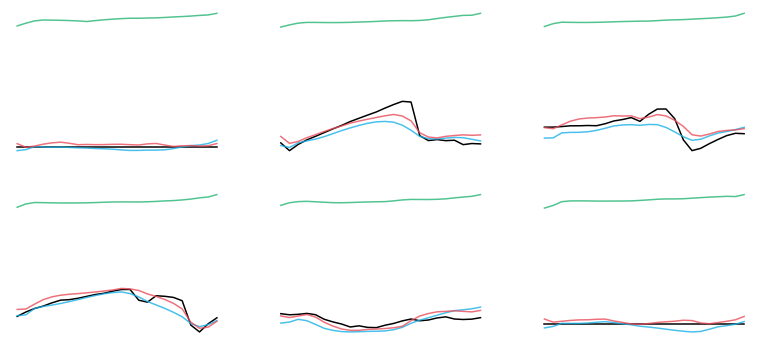

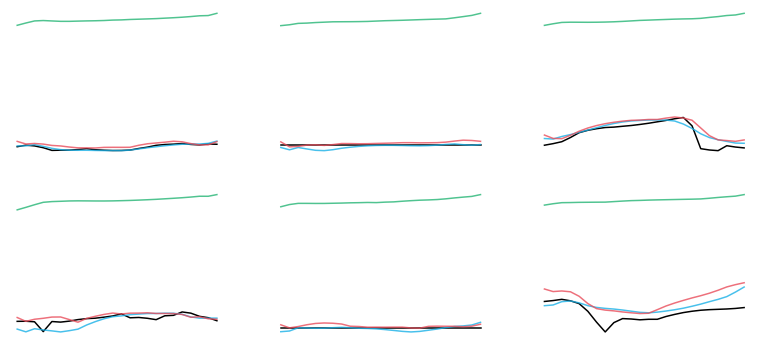

In [71]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (6):

        NUMBERS = np.arange(1, ae_lstm_pred.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*4, (6/2.54)*4))
        
        i=-2
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, ((MAXS-MINS)*test_label + MINS)[NUMBER, :, i], c='k', alpha=1) #measured
            expect1 = plt.plot(x_t, ((MAXS-MINS)*ae_bilstm_pred + MINS)[NUMBER, :, i], c=cmap[3], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, ((MAXS-MINS)*raw_ae_bilstm_pred + MINS)[NUMBER, :, i], c=cmap[4], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, ((MAXS-MINS)*trans_ae_bilstm_pred + MINS)[NUMBER, :, i], c=cmap[0], alpha=0.8) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1

In [72]:
ae_lstm_pred = tf.cast((MAXS-MINS)*ae_lstm_pred + MINS, tf.float32).numpy()
ae_bilstm_pred = tf.cast((MAXS-MINS)*ae_bilstm_pred + MINS, tf.float32).numpy()
raw_ae_lstm_pred = tf.cast((MAXS-MINS)*raw_ae_lstm_pred + MINS, tf.float32).numpy()
raw_ae_bilstm_pred = tf.cast((MAXS-MINS)*raw_ae_bilstm_pred + MINS, tf.float32).numpy()
trans_ae_lstm_pred = tf.cast((MAXS-MINS)*trans_ae_lstm_pred + MINS, tf.float32).numpy()
trans_ae_bilstm_pred = tf.cast((MAXS-MINS)*trans_ae_bilstm_pred + MINS, tf.float32).numpy()

In [73]:
pd.DataFrame(((MAXS-MINS)*test_label + MINS).reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/tom_tr_test_label2.csv')

In [74]:
pd.DataFrame(ae_lstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/tom_prev_ae_lstm_pred.csv')
pd.DataFrame(ae_bilstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/tom_prev_ae_bilstm_pred.csv')
pd.DataFrame(raw_ae_lstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/tom_raw_ae_lstm_pred.csv')
pd.DataFrame(raw_ae_bilstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/tom_raw_ae_bilstm_pred.csv')
pd.DataFrame(trans_ae_lstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/tom_tr_ae_lstm_pred.csv')
pd.DataFrame(trans_ae_bilstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/tom_tr_ae_bilstm_pred.csv')